# CM20219 – Convolution Lab
This lab implements image convolution of greyscale images and is worth 3.3% of marks for the unit.

Convolution a basic image filtering operation that is implemented in:
* many computer vision systems (e.g. for edge detection),
* most image editing programs such as Photoshop (e.g. for image sharpening), and
* many deep learning systems, e.g. for convolutional neural networks (CNNs).

Let us start by preparing the notebook, and loading and preparing a test image.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy, scipy.misc, scipy.ndimage

In [2]:
## Make figures larger
plt.rcParams['figure.figsize'] = [10, 6]

## Try commenting this out if plots look blurry on your screen.
# %config InlineBackend.figure_format = 'retina'

'image_int' has shape (512, 512) and datatype int64


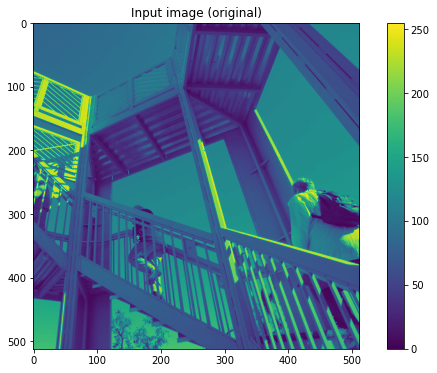

In [3]:
## Load a built-in test image.
image_int = scipy.misc.ascent()
print(f"'image_int' has shape {image_int.shape} and datatype {image_int.dtype}")

## Display the input image.
## Note that Matplotlib by default uses a colour map for single-channel images.
## The colour map is illustrated using the colour bar on the right.
plt.imshow(image_int)
plt.title('Input image (original)')
plt.colorbar();  # The semicolon suppresses the return value of the function.

'image' has shape (512, 512) and datatype float64


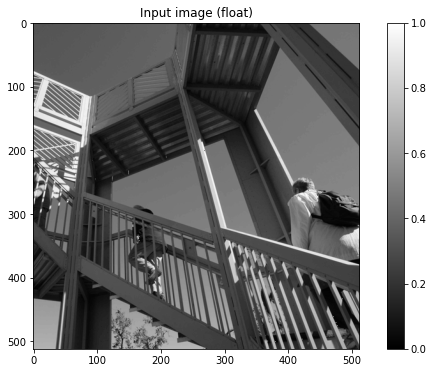

In [4]:
## Convert the image from integer 0..255 to float 0..1 for easier processing.
image = image_int.astype('float') / 255
print(f"'image' has shape {image.shape} and datatype {image.dtype}")

## Here, we override the default colour map using 'gray[scale]',
## and set the range of displayed values to vmin..vmax = 0..1.
plt.imshow(image, cmap='gray', vmin=0, vmax=1)
plt.title('Input image (float)')
plt.colorbar();

'image_crop' has shape (100, 100) and datatype float64


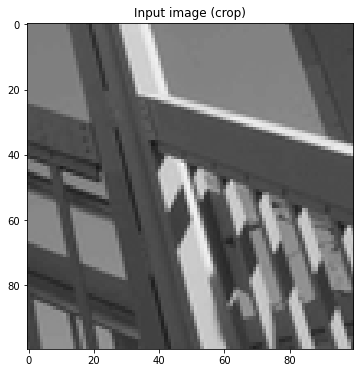

In [5]:
## Lets us crop out a subimage as a test image.
image_crop = image[300:400, 260:360]
print(f"'image_crop' has shape {image_crop.shape} and datatype {image_crop.dtype}")

## Display the image.
plt.imshow(image_crop, cmap='gray', vmin=0, vmax=1)
plt.title('Input image (crop)');

----
## 1. Basic convolution [40 marks]

Implement basic convolution by translating the pseudo-code below to Python.

Fill in the `basic_convolution(image, kernel)` below, which takes as input a grayscale `image` (2D matrix) and a filtering `kernel` (2D matrix), and returns the convolved image result as a greyscale image with the same size and datatype as the input image.

This operation can be described by the following pseudocode:
```
for each image row in input image:
    for each pixel in image row:
        set accumulator to zero
        
        for each kernel row in kernel:
            for each element in kernel row:
                if element position <corresponding to> pixel position then
                    multiply element value <corresponding to> pixel value
                    add result to accumulator
                endif

        set output image pixel to accumulator
```
(`<corresponding to>` input image pixels are found relative to the kernel’s origin)

Source: https://en.wikipedia.org/wiki/Kernel_(image_processing)#Convolution

In [6]:
def basic_convolution(image, kernel, verbose=False):
    ## TASK: Replace this code with your own implementation of convolution.

    convoluted_image = np.zeros_like(image)
    middle = kernel.shape[0]//2

    for image_row in range(middle*2,image.shape[0]): #go through every single row    middle*2 because placing the value in bottom right corner of kernel
        for pixel in range(middle*2,image.shape[1]): #go through every column in that row (each element)
            accumulator = 0
            for kernel_row in range(kernel.shape[0]): #go through every single row
                for element in range(kernel.shape[1]): #go through every column in that row (each element)
                    result = kernel[kernel_row][element] * image[image_row-kernel_row][pixel-element]
                    accumulator += result
            
            convoluted_image[image_row][pixel] = accumulator

    return convoluted_image

### Test your result

Demonstrate the functionality of your function by running the following cell.
Does you result looked blurry?

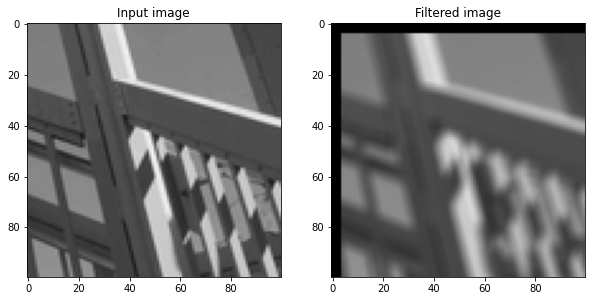

In [7]:
## Prepare a small convolution kernel (good for basic convolution).
kernel = np.ones([5, 5])
kernel = kernel / kernel.sum()  # normalise kernel

result1 = basic_convolution(image_crop, kernel)

## Display input image on the left.
plt.subplot(1, 2, 1); plt.title('Input image'); plt.imshow(image_crop, cmap='gray', vmin=0, vmax=1)

## Display filtered image on the right.
plt.subplot(1, 2, 2); plt.title('Filtered image'); plt.imshow(result1, cmap='gray', vmin=0, vmax=1);

----
## 2.	Border handling [20 marks]

Improve your implementation from the previous exercise:
1. Centre the filtered image, so that the content of the input and filtered images is not shifted between them; and
2. Fill in the border regions by extending/replicating the edge pixels of the image (‘clamp-to-edge’).

In [8]:
def extended_convolution(image, kernel, verbose=False):
    'Computes the convolution of an image with a kernel, with clamp-to-edge.'
    top_middle = kernel.shape[0]//2
    sides_middle = kernel.shape[1]//2
    
    image = np.pad(image, ((top_middle,top_middle),(sides_middle,sides_middle)), 'edge') #((top, bottom), (left, right)) #(104, 104)
    convoluted_image = np.zeros_like(image) #(104, 104)

    for image_row in range(image.shape[0]-top_middle): #go through every single row
        for pixel in range(image.shape[1]-sides_middle): #go through every column in that row (each element)
            accumulator = 0
            for kernel_row in range(kernel.shape[0]): #go through every single row
                for element in range(kernel.shape[1]): #go through every column in that row (each element)
                    result = kernel[kernel_row][element] * image[image_row-kernel_row+top_middle][pixel-element+sides_middle]
                    accumulator += result
            
            convoluted_image[image_row][pixel] = accumulator #(104, 104)

            
    #delete the extra border make it back to 100,100
    convoluted_image = convoluted_image[top_middle:-top_middle,sides_middle:-sides_middle]
    
    return convoluted_image #(100, 100)

### Test your result

A perfect result will match SciPy’s function `convolve` (with `mode='nearest'`) exactly, i.e. with a sum of squared differences (SSD) of 0 (zero):

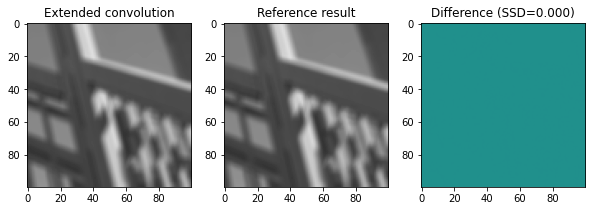

In [9]:
kernel = np.random.rand(5, 5)
kernel = kernel / kernel.sum()  # normalise kernel
image_crop = image[300:400,260:360]
filtered = extended_convolution(image_crop, kernel)
reference = scipy.ndimage.convolve(image_crop, kernel, mode='nearest')
ssd = np.sum(np.power(filtered - reference, 2))

plt.subplot(1, 3, 1); plt.title('Extended convolution');        plt.imshow(filtered,  cmap='gray', vmin=0,  vmax=1)
plt.subplot(1, 3, 2); plt.title('Reference result');            plt.imshow(reference, cmap='gray', vmin=0,  vmax=1)
plt.subplot(1, 3, 3); plt.title(f'Difference (SSD={ssd:.3f})'); plt.imshow(filtered - reference,   vmin=-1, vmax=1);

----
## 3. Image filtering [10 marks]

a) Design and demonstrate 3×3 convolution kernels for:
* computing horizontal, vertical and (any) diagonal image gradients, and
* sharpening an image using unsharp masking.

In [10]:
## TASK: edit the gradient kernels:
hgrad = np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]])  # horizontal gradients
vgrad = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])  # vertical gradients
dgrad = np.array([[2, 1, 0], [1, 0, -1], [0, -1, -2]])  # diagonal gradients (any direction)

print("horizontal gradient kernel:"); print(hgrad); print()
print("vertical gradient kernel:");   print(vgrad); print()
print("diagonal gradient kernel:");   print(dgrad)

horizontal gradient kernel:
[[ 1  0 -1]
 [ 2  0 -2]
 [ 1  0 -1]]

vertical gradient kernel:
[[ 1  2  1]
 [ 0  0  0]
 [-1 -2 -1]]

diagonal gradient kernel:
[[ 2  1  0]
 [ 1  0 -1]
 [ 0 -1 -2]]


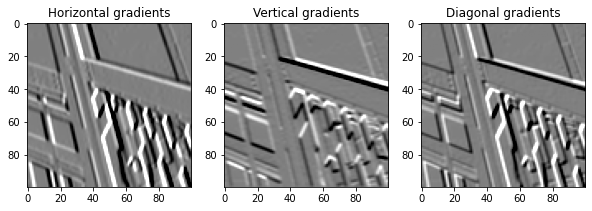

In [11]:
## Perform convolutions with the gradient kernels
hgrad_result = scipy.ndimage.convolve(image_crop, hgrad, mode='nearest')
vgrad_result = scipy.ndimage.convolve(image_crop, vgrad, mode='nearest')
dgrad_result = scipy.ndimage.convolve(image_crop, dgrad, mode='nearest')

## Show results
plt.subplot(1, 3, 1); plt.title('Horizontal gradients'); plt.imshow(hgrad_result, cmap='gray', vmin=-1, vmax=1)
plt.subplot(1, 3, 2); plt.title('Vertical gradients');   plt.imshow(vgrad_result, cmap='gray', vmin=-1, vmax=1)
plt.subplot(1, 3, 3); plt.title('Diagonal gradients');   plt.imshow(dgrad_result, cmap='gray', vmin=-1, vmax=1);

Unsharp masking kernel:
[[ 0 -1  0]
 [-1  5 -1]
 [ 0 -1  0]]


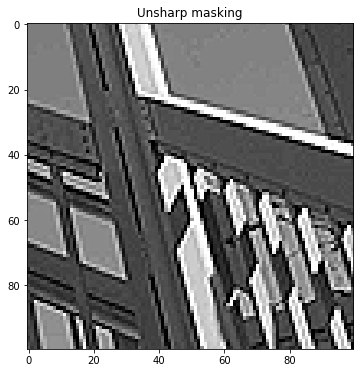

In [12]:
## TASK: unsharp masking kernel
usm = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])

print("Unsharp masking kernel:"); print(usm)
usm_result = scipy.ndimage.convolve(image_crop, usm, mode='nearest')
plt.title('Unsharp masking'); plt.imshow(usm_result, cmap='gray', vmin=0, vmax=1);

b) Compute the kernel for a 5×5 Gaussian blur with a standard deviation of 1 pixel.
Make sure that the kernel is normalised.

Gaussian 5x5 kernel:
[[0.00296902 0.01330621 0.02193823 0.01330621 0.00296902]
 [0.01330621 0.0596343  0.09832033 0.0596343  0.01330621]
 [0.02193823 0.09832033 0.16210282 0.09832033 0.02193823]
 [0.01330621 0.0596343  0.09832033 0.0596343  0.01330621]
 [0.00296902 0.01330621 0.02193823 0.01330621 0.00296902]]

Sum of elements: 1.0


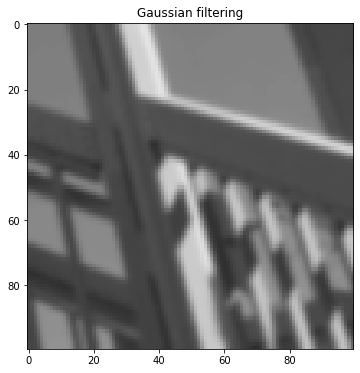

In [13]:
## TASK: 5x5 Gaussian kernel with standard deviation of 1 pixel
gauss = np.zeros([5, 5])
sd = 1
middle = gauss.shape[0]//2 #middle is [2,2]

for i in range(gauss.shape[0]):
    for j in range(gauss.shape[1]):
        x = j - middle
        y = i - middle
        gaussian = (1 / 2*np.pi*(sd**2)) * np.exp((-((x**2 + y**2)/2*(sd)**2)))
        gauss[i][j] = gaussian
        
for a in range(gauss.shape[0]):
    for b in range(gauss.shape[1]):
        gauss /= np.sum(gauss)

print("Gaussian 5x5 kernel:"); print(gauss)
print(f"\nSum of elements: {gauss.sum()}")
gauss_result = scipy.ndimage.convolve(image_crop, gauss, mode='nearest')
plt.title('Gaussian filtering'); plt.imshow(gauss_result, cmap='gray', vmin=0, vmax=1);

----
## 4.	Exploiting the convolution theorem [30 marks]

Apply the convolution theorem to speed up the convolution.

You can use NumPy’s functions for 2D Fast Fourier Transform (FFT), `np.fft.fft2` and its inverse `np.fft.ifft2`.

In [14]:
def fft_convolution(image, kernel):
    'Computes the convolution of an image with a kernel using FFT.'
    ## TASK: Replace this code with your own implementation of convolution.
    top_middle = kernel.shape[0]//2
    sides_middle = kernel.shape[1]//2
    
    image = np.pad(image, ((top_middle,top_middle),(sides_middle,sides_middle)), 'edge') #((top, bottom), (left, right)) #(102, 102)
    convoluted_image = np.zeros_like(image) #(102, 102)
    
    image = np.fft.fft2(image)
    
    #first make the kernel the same size as image.shape (pad with zeros)
    kernel_x = kernel.shape[0]
    kernel_y = kernel.shape[1]
    image_x = image.shape[0]
    image_y = image.shape[1]
    
    kernel = np.pad(kernel, [(0, image_x-kernel_x), (0, image_y-kernel_y)], 'constant') #top, bottom,left, right

    #apply fourier transform on kernel
    kernel = np.fft.fft2(kernel)
    
    #multiply image with kernel
    convoluted_image = kernel*image
    
    #use inverse fourier transform with image
    convoluted_image = np.abs(np.fft.ifft2(convoluted_image))
    #convoluted_image = convoluted_image[middle:-middle,middle:-middle]
    
    convoluted_image = convoluted_image[top_middle*2:,sides_middle*2:]
    
    return convoluted_image

### Test your result

A perfect result will match SciPy’s function `convolve` (with `mode='nearest'`) exactly, i.e. with a sum of squared differences (SSD) of 0 (zero):

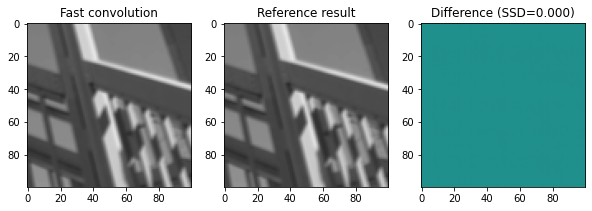

In [15]:
kernel = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
kernel = kernel / kernel.sum()  # normalise kernel

filtered = fft_convolution(image_crop, kernel)
reference = scipy.ndimage.convolve(image_crop, kernel, mode='nearest')
ssd = np.sum(np.power(filtered - reference, 2))

plt.subplot(1, 3, 1); plt.title('Fast convolution');            plt.imshow(filtered,  cmap='gray', vmin=0,  vmax=1)
plt.subplot(1, 3, 2); plt.title('Reference result');            plt.imshow(reference, cmap='gray', vmin=0,  vmax=1)
plt.subplot(1, 3, 3); plt.title(f'Difference (SSD={ssd:.3f})'); plt.imshow(filtered - reference,   vmin=-1, vmax=1);

### Run-time comparison *(optional)*

You can use the following code to compare the run times of your FFT-based convolution function with “extended_convolution” above for different kernel sizes.
Please this code comment out when submitting your code, as it slows down the marking process.

In [16]:
#import time

#print('Kernel size  | Naive (crop) | FFT (crop) | FFT (full image)')
#for kernel_size in range(1, 10):
    #print(f"{kernel_size}-by-{kernel_size}".center(13), end='')
    #kernel = np.ones([kernel_size, kernel_size]) / kernel_size ** 2

    #tic = time.time()
    #result = extended_convolution(image_crop, kernel)
    #elapsed = time.time() - tic
    #print(f"| {elapsed:12.3f} ", end='')
    
    #tic = time.time()
    #result = fft_convolution(image_crop, kernel)
    #elapsed = time.time() - tic
    #print(f"| {elapsed:10.3f} ", end='')

    #tic = time.time()
    #result = fft_convolution(image, kernel)
    #elapsed = time.time() - tic
    #print(f"| {elapsed:10.3f}")